In [1]:
%%capture
!pip install tables
!pip install --upgrade --force-reinstall tensorflow
!pip install keras-tuner
!pip install pytorch-tabnet
from pytorch_tabnet.metrics import Metric
import os, gc, pickle, datetime, scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from colorama import Fore, Back, Style

import torch
from pytorch_tabnet.tab_model import TabNetRegressor

from sklearn.model_selection import GroupKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from cycler import cycler
from IPython.display import display

import scipy.sparse
import scprep

def correlation_score(y_true, y_pred):
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(y_true.shape[0]):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

def negative_correlation_loss(y_true, y_pred):
    my = K.mean(tf.convert_to_tensor(y_pred), axis=1)
    my = tf.tile(tf.expand_dims(my, axis=1), (1, tf.shape(y_true)[1]))
    ym = y_pred - my
    r_num = K.sum(tf.multiply(y_true, ym), axis=1)
    r_den = tf.sqrt(K.sum(K.square(ym), axis=1) * float(tf.shape(y_true)[-1]))
    r = tf.reduce_mean(r_num / r_den)
    return - r

def negative_pearson_loss(y_true, y_pred):
    """Negative correlation loss function for Pytorch
    Precondition:
    y_true.mean(axis=1) == 0
    y_true.std(axis=1) == 1
    Returns:
    -1 = perfect positive correlation
    1 = totally negative correlation
    """
    vx = y_pred - torch.mean(y_pred,1,keepdim=True)
    vy = y_true - torch.mean(y_true,1,keepdim=True)
    cost = torch.mean(torch.sum(vx * vy,1) / (torch.sqrt(torch.sum(vx ** 2,1)) * torch.sqrt(torch.sum(vy ** 2,1))))
    return - cost

class Pytorch_Metric(Metric):
    def __init__(self):
        self._name = "pearson"
        self._maximize = False

    def __call__(self, y_true, y_score):
        return negative_pearson_loss(torch.Tensor(y_true), torch.Tensor(y_score))

from sklearn.model_selection import train_test_split
import scprep

import math
import tensorflow as tf
import keras_tuner
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, BatchNormalization
LR_START = 0.01
BATCH_SIZE = 512

best_hp = keras_tuner.HyperParameters()
best_hp.values = {'reg1': 0.0001,
                'reg2': 3.307e-07,
                'units1': 1024,
                'units2': 1024,
                'units3': 1024,
                'lr': 0.001
                 }

LR_START = 0.01
BATCH_SIZE = 512

def create_model(input_shape, output_shape):
    
    reg1 = 9.613e-06
    reg2 = 1e-07
    REG1 = tf.keras.regularizers.l2(reg1)
    REG2 = tf.keras.regularizers.l2(reg2)
    DROP = 0.1

    activation = 'selu'
    inputs = Input(shape =(input_shape,))

    x0 = Dense(256, 
              kernel_regularizer = REG1,
              activation = activation,
             )(inputs)
    x0 = Dropout(DROP)(x0)
    
    
    x1 = Dense(512, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x0)
    x1 = Dropout(DROP)(x1)
    
    
    x2 = Dense(512, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x1) 
    x2= Dropout(DROP)(x2)
    
    x3 = Dense(output_shape,
               kernel_regularizer = REG1,
               activation = activation,
             )(x2)
    x3 = Dropout(DROP)(x3)

         
    x = Concatenate()([
                x0, 
                x1, 
                x2, 
                x3
                ])
    
    x = Dense(output_shape, 
                kernel_regularizer = REG2,
                activation='linear',
                )(x)
    
    
    model = Model(inputs, x)
    

    return model

2022-11-10 16:39:57.413234: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 16:39:57.638179: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-10 16:39:57.693716: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-10 16:39:58.545004: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [89]:
# constant_cols = list(X.columns[(X == 0).all(axis=0).values]) + list(X_test.columns[(X_test == 0).all(axis=0).values])
constant_cols = ['ENSG00000003137_CYP26B1', 'ENSG00000004848_ARX', 'ENSG00000006606_CCL26', 'ENSG00000010379_SLC6A13', 'ENSG00000010932_FMO1', 'ENSG00000017427_IGF1', 'ENSG00000022355_GABRA1', 'ENSG00000041982_TNC', 'ENSG00000060709_RIMBP2', 'ENSG00000064886_CHI3L2', 'ENSG00000065717_TLE2', 'ENSG00000067798_NAV3', 'ENSG00000069535_MAOB', 'ENSG00000073598_FNDC8', 'ENSG00000074219_TEAD2', 'ENSG00000074964_ARHGEF10L', 'ENSG00000077264_PAK3', 'ENSG00000078053_AMPH', 'ENSG00000082684_SEMA5B', 'ENSG00000083857_FAT1', 'ENSG00000084628_NKAIN1', 'ENSG00000084734_GCKR', 'ENSG00000086967_MYBPC2', 'ENSG00000087258_GNAO1', 'ENSG00000089505_CMTM1', 'ENSG00000091129_NRCAM', 'ENSG00000091986_CCDC80', 'ENSG00000092377_TBL1Y', 'ENSG00000092969_TGFB2', 'ENSG00000095397_WHRN', 'ENSG00000095970_TREM2', 'ENSG00000099715_PCDH11Y', 'ENSG00000100197_CYP2D6', 'ENSG00000100218_RSPH14', 'ENSG00000100311_PDGFB', 'ENSG00000100362_PVALB', 'ENSG00000100373_UPK3A', 'ENSG00000100625_SIX4', 'ENSG00000100867_DHRS2', 'ENSG00000100985_MMP9', 'ENSG00000101197_BIRC7', 'ENSG00000101298_SNPH', 'ENSG00000102387_TAF7L', 'ENSG00000103034_NDRG4', 'ENSG00000104059_FAM189A1', 'ENSG00000104112_SCG3', 'ENSG00000104313_EYA1', 'ENSG00000104892_KLC3', 'ENSG00000105088_OLFM2', 'ENSG00000105261_OVOL3', 'ENSG00000105290_APLP1', 'ENSG00000105507_CABP5', 'ENSG00000105642_KCNN1', 'ENSG00000105694_ELOCP28', 'ENSG00000105707_HPN', 'ENSG00000105894_PTN', 'ENSG00000106018_VIPR2', 'ENSG00000106541_AGR2', 'ENSG00000107317_PTGDS', 'ENSG00000108688_CCL7', 'ENSG00000108702_CCL1', 'ENSG00000108947_EFNB3', 'ENSG00000109193_SULT1E1', 'ENSG00000109794_FAM149A', 'ENSG00000109832_DDX25', 'ENSG00000110195_FOLR1', 'ENSG00000110375_UPK2', 'ENSG00000110436_SLC1A2', 'ENSG00000111339_ART4', 'ENSG00000111863_ADTRP', 'ENSG00000112761_WISP3', 'ENSG00000112852_PCDHB2', 'ENSG00000114251_WNT5A', 'ENSG00000114279_FGF12', 'ENSG00000114455_HHLA2', 'ENSG00000114757_PEX5L', 'ENSG00000115155_OTOF', 'ENSG00000115266_APC2', 'ENSG00000115297_TLX2', 'ENSG00000115590_IL1R2', 'ENSG00000115844_DLX2', 'ENSG00000116194_ANGPTL1', 'ENSG00000116661_FBXO2', 'ENSG00000116774_OLFML3', 'ENSG00000117322_CR2', 'ENSG00000117971_CHRNB4', 'ENSG00000118322_ATP10B', 'ENSG00000118402_ELOVL4', 'ENSG00000118520_ARG1', 'ENSG00000118946_PCDH17', 'ENSG00000118972_FGF23', 'ENSG00000119771_KLHL29', 'ENSG00000120549_KIAA1217', 'ENSG00000121316_PLBD1', 'ENSG00000121905_HPCA', 'ENSG00000122224_LY9', 'ENSG00000124194_GDAP1L1', 'ENSG00000124440_HIF3A', 'ENSG00000124657_OR2B6', 'ENSG00000125462_C1orf61', 'ENSG00000125895_TMEM74B', 'ENSG00000126838_PZP', 'ENSG00000128422_KRT17', 'ENSG00000128918_ALDH1A2', 'ENSG00000129170_CSRP3', 'ENSG00000129214_SHBG', 'ENSG00000129673_AANAT', 'ENSG00000129910_CDH15', 'ENSG00000130294_KIF1A', 'ENSG00000130307_USHBP1', 'ENSG00000130545_CRB3', 'ENSG00000131019_ULBP3', 'ENSG00000131044_TTLL9', 'ENSG00000131183_SLC34A1', 'ENSG00000131386_GALNT15', 'ENSG00000131400_NAPSA', 'ENSG00000131914_LIN28A', 'ENSG00000131941_RHPN2', 'ENSG00000131951_LRRC9', 'ENSG00000132170_PPARG', 'ENSG00000132681_ATP1A4', 'ENSG00000132958_TPTE2', 'ENSG00000133454_MYO18B', 'ENSG00000134545_KLRC1', 'ENSG00000134853_PDGFRA', 'ENSG00000135083_CCNJL', 'ENSG00000135100_HNF1A', 'ENSG00000135116_HRK', 'ENSG00000135312_HTR1B', 'ENSG00000135324_MRAP2', 'ENSG00000135436_FAM186B', 'ENSG00000135472_FAIM2', 'ENSG00000135898_GPR55', 'ENSG00000135929_CYP27A1', 'ENSG00000136002_ARHGEF4', 'ENSG00000136099_PCDH8', 'ENSG00000136274_NACAD', 'ENSG00000137078_SIT1', 'ENSG00000137142_IGFBPL1', 'ENSG00000137473_TTC29', 'ENSG00000137474_MYO7A', 'ENSG00000137491_SLCO2B1', 'ENSG00000137691_CFAP300', 'ENSG00000137731_FXYD2', 'ENSG00000137747_TMPRSS13', 'ENSG00000137878_GCOM1', 'ENSG00000138411_HECW2', 'ENSG00000138741_TRPC3', 'ENSG00000138769_CDKL2', 'ENSG00000138823_MTTP', 'ENSG00000139908_TSSK4', 'ENSG00000140832_MARVELD3', 'ENSG00000142178_SIK1', 'ENSG00000142538_PTH2', 'ENSG00000142910_TINAGL1', 'ENSG00000143217_NECTIN4', 'ENSG00000143858_SYT2', 'ENSG00000144130_NT5DC4', 'ENSG00000144214_LYG1', 'ENSG00000144290_SLC4A10', 'ENSG00000144366_GULP1', 'ENSG00000144583_MARCH4', 'ENSG00000144771_LRTM1', 'ENSG00000144891_AGTR1', 'ENSG00000145087_STXBP5L', 'ENSG00000145107_TM4SF19', 'ENSG00000146197_SCUBE3', 'ENSG00000146966_DENND2A', 'ENSG00000147082_CCNB3', 'ENSG00000147614_ATP6V0D2', 'ENSG00000147642_SYBU', 'ENSG00000147869_CER1', 'ENSG00000149403_GRIK4', 'ENSG00000149596_JPH2', 'ENSG00000150630_VEGFC', 'ENSG00000150722_PPP1R1C', 'ENSG00000151631_AKR1C6P', 'ENSG00000151704_KCNJ1', 'ENSG00000152154_TMEM178A', 'ENSG00000152292_SH2D6', 'ENSG00000152315_KCNK13', 'ENSG00000152503_TRIM36', 'ENSG00000153253_SCN3A', 'ENSG00000153902_LGI4', 'ENSG00000153930_ANKFN1', 'ENSG00000154040_CABYR', 'ENSG00000154118_JPH3', 'ENSG00000154175_ABI3BP', 'ENSG00000154645_CHODL', 'ENSG00000157060_SHCBP1L', 'ENSG00000157087_ATP2B2', 'ENSG00000157152_SYN2', 'ENSG00000157168_NRG1', 'ENSG00000157680_DGKI', 'ENSG00000158246_TENT5B', 'ENSG00000158477_CD1A', 'ENSG00000158481_CD1C', 'ENSG00000158488_CD1E', 'ENSG00000159189_C1QC', 'ENSG00000159217_IGF2BP1', 'ENSG00000160683_CXCR5', 'ENSG00000160801_PTH1R', 'ENSG00000160973_FOXH1', 'ENSG00000161594_KLHL10', 'ENSG00000162409_PRKAA2', 'ENSG00000162840_MT2P1', 'ENSG00000162873_KLHDC8A', 'ENSG00000162944_RFTN2', 'ENSG00000162949_CAPN13', 'ENSG00000163116_STPG2', 'ENSG00000163288_GABRB1', 'ENSG00000163531_NFASC', 'ENSG00000163618_CADPS', 'ENSG00000163637_PRICKLE2', 'ENSG00000163735_CXCL5', 'ENSG00000163873_GRIK3', 'ENSG00000163898_LIPH', 'ENSG00000164061_BSN', 'ENSG00000164078_MST1R', 'ENSG00000164123_C4orf45', 'ENSG00000164690_SHH', 'ENSG00000164761_TNFRSF11B', 'ENSG00000164821_DEFA4', 'ENSG00000164845_FAM86FP', 'ENSG00000164867_NOS3', 'ENSG00000166073_GPR176', 'ENSG00000166148_AVPR1A', 'ENSG00000166250_CLMP', 'ENSG00000166257_SCN3B', 'ENSG00000166268_MYRFL', 'ENSG00000166523_CLEC4E', 'ENSG00000166535_A2ML1', 'ENSG00000166819_PLIN1', 'ENSG00000166928_MS4A14', 'ENSG00000167210_LOXHD1', 'ENSG00000167306_MYO5B', 'ENSG00000167634_NLRP7', 'ENSG00000167748_KLK1', 'ENSG00000167889_MGAT5B', 'ENSG00000168140_VASN', 'ENSG00000168546_GFRA2', 'ENSG00000168646_AXIN2', 'ENSG00000168955_TM4SF20', 'ENSG00000168993_CPLX1', 'ENSG00000169075_Z99496.1', 'ENSG00000169194_IL13', 'ENSG00000169246_NPIPB3', 'ENSG00000169884_WNT10B', 'ENSG00000169900_PYDC1', 'ENSG00000170074_FAM153A', 'ENSG00000170075_GPR37L1', 'ENSG00000170289_CNGB3', 'ENSG00000170356_OR2A20P', 'ENSG00000170537_TMC7', 'ENSG00000170689_HOXB9', 'ENSG00000170827_CELP', 'ENSG00000171346_KRT15', 'ENSG00000171368_TPPP', 'ENSG00000171501_OR1N2', 'ENSG00000171532_NEUROD2', 'ENSG00000171611_PTCRA', 'ENSG00000171873_ADRA1D', 'ENSG00000171916_LGALS9C', 'ENSG00000172005_MAL', 'ENSG00000172987_HPSE2', 'ENSG00000173068_BNC2', 'ENSG00000173077_DEC1', 'ENSG00000173210_ABLIM3', 'ENSG00000173267_SNCG', 'ENSG00000173369_C1QB', 'ENSG00000173372_C1QA', 'ENSG00000173391_OLR1', 'ENSG00000173626_TRAPPC3L', 'ENSG00000173698_ADGRG2', 'ENSG00000173868_PHOSPHO1', 'ENSG00000174407_MIR1-1HG', 'ENSG00000174807_CD248', 'ENSG00000175206_NPPA', 'ENSG00000175746_C15orf54', 'ENSG00000175985_PLEKHD1', 'ENSG00000176043_AC007160.1', 'ENSG00000176399_DMRTA1', 'ENSG00000176510_OR10AC1', 'ENSG00000176697_BDNF', 'ENSG00000176826_FKBP9P1', 'ENSG00000176988_FMR1NB', 'ENSG00000177324_BEND2', 'ENSG00000177335_C8orf31', 'ENSG00000177535_OR2B11', 'ENSG00000177614_PGBD5', 'ENSG00000177707_NECTIN3', 'ENSG00000178033_CALHM5', 'ENSG00000178175_ZNF366', 'ENSG00000178462_TUBAL3', 'ENSG00000178732_GP5', 'ENSG00000178750_STX19', 'ENSG00000179058_C9orf50', 'ENSG00000179101_AL590139.1', 'ENSG00000179388_EGR3', 'ENSG00000179611_DGKZP1', 'ENSG00000179899_PHC1P1', 'ENSG00000179934_CCR8', 'ENSG00000180537_RNF182', 'ENSG00000180712_LINC02363', 'ENSG00000180988_OR52N2', 'ENSG00000181001_OR52N1', 'ENSG00000181616_OR52H1', 'ENSG00000181634_TNFSF15', 'ENSG00000182021_AL591379.1', 'ENSG00000182230_FAM153B', 'ENSG00000182853_VMO1', 'ENSG00000183090_FREM3', 'ENSG00000183562_AC131971.1', 'ENSG00000183615_FAM167B', 'ENSG00000183625_CCR3', 'ENSG00000183770_FOXL2', 'ENSG00000183779_ZNF703', 'ENSG00000183831_ANKRD45', 'ENSG00000183844_FAM3B', 'ENSG00000183960_KCNH8', 'ENSG00000184106_TREML3P', 'ENSG00000184227_ACOT1', 'ENSG00000184363_PKP3', 'ENSG00000184434_LRRC19', 'ENSG00000184454_NCMAP', 'ENSG00000184571_PIWIL3', 'ENSG00000184702_SEPT5', 'ENSG00000184908_CLCNKB', 'ENSG00000184923_NUTM2A', 'ENSG00000185070_FLRT2', 'ENSG00000185156_MFSD6L', 'ENSG00000185567_AHNAK2', 'ENSG00000185686_PRAME', 'ENSG00000186190_BPIFB3', 'ENSG00000186191_BPIFB4', 'ENSG00000186231_KLHL32', 'ENSG00000186431_FCAR', 'ENSG00000186715_MST1L', 'ENSG00000187116_LILRA5', 'ENSG00000187185_AC092118.1', 'ENSG00000187268_FAM9C', 'ENSG00000187554_TLR5', 'ENSG00000187867_PALM3', 'ENSG00000188153_COL4A5', 'ENSG00000188158_NHS', 'ENSG00000188163_FAM166A', 'ENSG00000188316_ENO4', 'ENSG00000188959_C9orf152', 'ENSG00000189013_KIR2DL4', 'ENSG00000189409_MMP23B', 'ENSG00000196092_PAX5', 'ENSG00000196260_SFTA2', 'ENSG00000197358_BNIP3P1', 'ENSG00000197446_CYP2F1', 'ENSG00000197540_GZMM', 'ENSG00000198049_AVPR1B', 'ENSG00000198134_AC007537.1', 'ENSG00000198156_NPIPB6', 'ENSG00000198221_AFDN-DT', 'ENSG00000198626_RYR2', 'ENSG00000198759_EGFL6', 'ENSG00000198822_GRM3', 'ENSG00000198963_RORB', 'ENSG00000199090_MIR326', 'ENSG00000199753_SNORD104', 'ENSG00000199787_RF00406', 'ENSG00000199872_RNU6-942P', 'ENSG00000200075_RF00402', 'ENSG00000200296_RNU1-83P', 'ENSG00000200683_RNU6-379P', 'ENSG00000201044_RNU6-268P', 'ENSG00000201343_RF00019', 'ENSG00000201564_RN7SKP50', 'ENSG00000201616_RNU1-91P', 'ENSG00000201737_RNU1-133P', 'ENSG00000202048_SNORD114-20', 'ENSG00000202415_RN7SKP269', 'ENSG00000203395_AC015969.1', 'ENSG00000203721_LINC00862', 'ENSG00000203727_SAMD5', 'ENSG00000203737_GPR52', 'ENSG00000203783_PRR9', 'ENSG00000203867_RBM20', 'ENSG00000203907_OOEP', 'ENSG00000203999_LINC01270', 'ENSG00000204010_IFIT1B', 'ENSG00000204044_SLC12A5-AS1', 'ENSG00000204091_TDRG1', 'ENSG00000204121_ECEL1P1', 'ENSG00000204165_CXorf65', 'ENSG00000204173_LRRC37A5P', 'ENSG00000204248_COL11A2', 'ENSG00000204424_LY6G6F', 'ENSG00000204539_CDSN', 'ENSG00000204583_LRCOL1', 'ENSG00000204677_FAM153C', 'ENSG00000204709_LINC01556', 'ENSG00000204711_C9orf135', 'ENSG00000204792_LINC01291', 'ENSG00000204850_AC011484.1', 'ENSG00000204851_PNMA8B', 'ENSG00000204909_SPINK9', 'ENSG00000205037_AC134312.1', 'ENSG00000205038_PKHD1L1', 'ENSG00000205089_CCNI2', 'ENSG00000205106_DKFZp779M0652', 'ENSG00000205364_MT1M', 'ENSG00000205502_C2CD4B', 'ENSG00000205746_AC126755.1', 'ENSG00000205856_C22orf42', 'ENSG00000206052_DOK6', 'ENSG00000206579_XKR4', 'ENSG00000206645_RF00019', 'ENSG00000206786_RNU6-701P', 'ENSG00000206846_RF00019', 'ENSG00000206848_RNU6-890P', 'ENSG00000207088_SNORA7B', 'ENSG00000207181_SNORA14B', 'ENSG00000207234_RNU6-125P', 'ENSG00000207326_RF00019', 'ENSG00000207359_RNU6-925P', 'ENSG00000211677_IGLC2', 'ENSG00000211699_TRGV3', 'ENSG00000211895_IGHA1', 'ENSG00000212385_RNU6-817P', 'ENSG00000212391_RF00554', 'ENSG00000212607_SNORA3B', 'ENSG00000212829_RPS26P3', 'ENSG00000213083_AC010731.1', 'ENSG00000213216_AC007066.1', 'ENSG00000213222_AC093724.1', 'ENSG00000213228_RPL12P38', 'ENSG00000213250_RBMS2P1', 'ENSG00000213272_RPL7AP9', 'ENSG00000213303_AC008481.1', 'ENSG00000213402_PTPRCAP', 'ENSG00000213471_TTLL13P', 'ENSG00000213588_ZBTB9', 'ENSG00000213609_RPL7AP50', 'ENSG00000213757_AC020898.1', 'ENSG00000213931_HBE1', 'ENSG00000213950_RPS10P2', 'ENSG00000213994_AL157395.1', 'ENSG00000214787_MS4A4E', 'ENSG00000214866_DCDC2C', 'ENSG00000214908_AL353678.1', 'ENSG00000214975_PPIAP29', 'ENSG00000215198_AL353795.1', 'ENSG00000215208_KRT18P60', 'ENSG00000215218_UBE2QL1', 'ENSG00000215297_AL354941.1', 'ENSG00000215464_AP000354.1', 'ENSG00000215483_LINC00598', 'ENSG00000215817_ZC3H11B', 'ENSG00000215861_AC245297.1', 'ENSG00000215910_C1orf167', 'ENSG00000216475_AL024474.1', 'ENSG00000217195_AL513475.1', 'ENSG00000217414_DDX18P3', 'ENSG00000217512_AL356776.1', 'ENSG00000218351_RPS3AP23', 'ENSG00000218418_AL591135.1', 'ENSG00000218749_AL033519.1', 'ENSG00000218766_AL450338.1', 'ENSG00000218792_HSPD1P16', 'ENSG00000219249_AMZ2P2', 'ENSG00000219395_HSPA8P15', 'ENSG00000219410_AC125494.1', 'ENSG00000219932_RPL12P8', 'ENSG00000220091_LAP3P1', 'ENSG00000220237_RPS24P12', 'ENSG00000220494_YAP1P1', 'ENSG00000221102_SNORA11B', 'ENSG00000221887_HMSD', 'ENSG00000222276_RNU2-33P', 'ENSG00000222370_SNORA36B', 'ENSG00000222421_RF00019', 'ENSG00000222431_RNU6-141P', 'ENSG00000223342_AL158817.1', 'ENSG00000223379_AL391987.3', 'ENSG00000223403_MEG9', 'ENSG00000223519_KIF28P', 'ENSG00000223576_AL355001.1', 'ENSG00000223668_EEF1A1P24', 'ENSG00000223741_PSMD4P1', 'ENSG00000223779_AC239800.1', 'ENSG00000223783_LINC01983', 'ENSG00000223784_LINP1', 'ENSG00000223855_HRAT92', 'ENSG00000223884_AC068481.1', 'ENSG00000223899_SEC13P1', 'ENSG00000224067_AL354877.1', 'ENSG00000224072_AL139811.1', 'ENSG00000224081_SLC44A3-AS1', 'ENSG00000224099_AC104823.1', 'ENSG00000224116_INHBA-AS1', 'ENSG00000224137_LINC01857', 'ENSG00000224155_AC073136.2', 'ENSG00000224321_RPL12P14', 'ENSG00000224402_OR6D1P', 'ENSG00000224479_AC104162.1', 'ENSG00000224599_BMS1P12', 'ENSG00000224689_ZNF812P', 'ENSG00000224848_AL589843.1', 'ENSG00000224908_TIMM8BP2', 'ENSG00000224957_LINC01266', 'ENSG00000224959_AC017002.1', 'ENSG00000224988_AL158207.1', 'ENSG00000224993_RPL29P12', 'ENSG00000225096_AL445250.1', 'ENSG00000225101_OR52K3P', 'ENSG00000225107_AC092484.1', 'ENSG00000225187_AC073283.1', 'ENSG00000225313_AL513327.1', 'ENSG00000225345_SNX18P3', 'ENSG00000225393_BX571846.1', 'ENSG00000225422_RBMS1P1', 'ENSG00000225423_TNPO1P1', 'ENSG00000225531_AL807761.2', 'ENSG00000225554_AL359764.1', 'ENSG00000225650_EIF2S2P5', 'ENSG00000225674_IPO7P2', 'ENSG00000225807_AC069281.1', 'ENSG00000226010_AL355852.1', 'ENSG00000226084_AC113935.1', 'ENSG00000226251_AL451060.1', 'ENSG00000226383_LINC01876', 'ENSG00000226491_FTOP1', 'ENSG00000226501_USF1P1', 'ENSG00000226545_AL357552.1', 'ENSG00000226564_FTH1P20', 'ENSG00000226617_RPL21P110', 'ENSG00000226647_AL365356.1', 'ENSG00000226800_CACTIN-AS1', 'ENSG00000226913_BSN-DT', 'ENSG00000226948_RPS4XP2', 'ENSG00000226970_AL450063.1', 'ENSG00000227006_AL136988.2', 'ENSG00000227051_C14orf132', 'ENSG00000227072_AL353706.1', 'ENSG00000227110_LMCD1-AS1', 'ENSG00000227192_AL023581.2', 'ENSG00000227198_C6orf47-AS1', 'ENSG00000227207_RPL31P12', 'ENSG00000227477_STK4-AS1', 'ENSG00000227541_SFR1P1', 'ENSG00000227590_ATP5MC1P5', 'ENSG00000227649_MTND6P32', 'ENSG00000227682_ATP5F1AP2', 'ENSG00000227740_AL513329.1', 'ENSG00000227742_CALR4P', 'ENSG00000228097_MTATP6P11', 'ENSG00000228140_AL031283.1', 'ENSG00000228175_GEMIN8P4', 'ENSG00000228212_OFD1P17', 'ENSG00000228232_GAPDHP1', 'ENSG00000228317_AL158070.1', 'ENSG00000228413_AC024937.1', 'ENSG00000228430_AL162726.3', 'ENSG00000228501_RPL15P18', 'ENSG00000228550_AC073583.1', 'ENSG00000228655_AC096558.1', 'ENSG00000228727_SAPCD1', 'ENSG00000228826_AL592494.1', 'ENSG00000228839_PIK3IP1-AS1', 'ENSG00000228863_AL121985.1', 'ENSG00000229066_AC093459.1', 'ENSG00000229150_CRYGEP', 'ENSG00000229154_KCNQ5-AS1', 'ENSG00000229163_NAP1L1P2', 'ENSG00000229236_TTTY10', 'ENSG00000229274_AL662860.1', 'ENSG00000229308_AC010737.1', 'ENSG00000229326_AC069154.1', 'ENSG00000229372_SZT2-AS1', 'ENSG00000229444_AL451062.1', 'ENSG00000229567_AL139421.1', 'ENSG00000229703_CR589904.1', 'ENSG00000229742_AC092809.1', 'ENSG00000229758_DYNLT3P2', 'ENSG00000229839_AC018462.1', 'ENSG00000229847_EMX2OS', 'ENSG00000229853_AL034418.1', 'ENSG00000229918_DOCK9-AS1', 'ENSG00000229953_AL590666.2', 'ENSG00000229992_HMGB3P9', 'ENSG00000230063_AL360091.2', 'ENSG00000230064_AL772161.1', 'ENSG00000230138_AC119428.2', 'ENSG00000230149_AL021707.3', 'ENSG00000230289_AL358781.2', 'ENSG00000230295_GTF2IP23', 'ENSG00000230479_AP000695.1', 'ENSG00000230508_RPL19P21', 'ENSG00000230519_HMGB1P49', 'ENSG00000230534_AL392046.1', 'ENSG00000230563_AL121757.1', 'ENSG00000230721_AL049597.1', 'ENSG00000230772_VN1R108P', 'ENSG00000230777_RPS29P5', 'ENSG00000230799_AC007279.1', 'ENSG00000230813_AL356583.3', 'ENSG00000230815_AL807757.1', 'ENSG00000230872_MFSD13B', 'ENSG00000230910_AL391807.1', 'ENSG00000230912_AL021707.4', 'ENSG00000230968_AC084149.2', 'ENSG00000230993_RPL12P15', 'ENSG00000231265_TRERNA1', 'ENSG00000231307_RPS3P2', 'ENSG00000231407_AL354732.1', 'ENSG00000231449_AC097359.1', 'ENSG00000231507_LINC01353', 'ENSG00000231531_HINT1P1', 'ENSG00000231548_OR55B1P', 'ENSG00000231731_AC010976.1', 'ENSG00000231742_LINC01273', 'ENSG00000231788_RPL31P50', 'ENSG00000231830_AC245140.1', 'ENSG00000231927_AC093734.1', 'ENSG00000231993_EP300-AS1', 'ENSG00000232027_AL671986.1', 'ENSG00000232028_AC007391.1', 'ENSG00000232065_LINC01063', 'ENSG00000232133_IMPDH1P10', 'ENSG00000232139_LINC00867', 'ENSG00000232273_FTH1P1', 'ENSG00000232333_RPS27AP2', 'ENSG00000232466_AL356133.1', 'ENSG00000232500_AP005273.1', 'ENSG00000232530_LIF-AS1', 'ENSG00000232568_RPL23AP35', 'ENSG00000232578_AC093311.1', 'ENSG00000232606_LINC01412', 'ENSG00000232654_FAM136BP', 'ENSG00000232656_IDI2-AS1', 'ENSG00000232719_AC007272.1', 'ENSG00000232803_SLCO4A1-AS1', 'ENSG00000232987_LINC01219', 'ENSG00000233025_CRYZP1', 'ENSG00000233093_LINC00892', 'ENSG00000233099_AC095030.1', 'ENSG00000233401_PRKAR1AP1', 'ENSG00000233427_AL009181.1', 'ENSG00000233540_DNM3-IT1', 'ENSG00000233674_AL451062.2', 'ENSG00000233825_AL391839.2', 'ENSG00000233862_AC016907.2', 'ENSG00000233994_GDI2P2', 'ENSG00000234026_AL157834.2', 'ENSG00000234106_SRP14P2', 'ENSG00000234145_NAP1L4P3', 'ENSG00000234174_AC016683.1', 'ENSG00000234271_Z98752.2', 'ENSG00000234425_AL138930.1', 'ENSG00000234488_AC096664.2', 'ENSG00000234630_AC245060.2', 'ENSG00000234645_YWHAEP5', 'ENSG00000234718_AC007161.1', 'ENSG00000234810_AL603840.1', 'ENSG00000235045_RPL7P8', 'ENSG00000235072_AC012074.1', 'ENSG00000235214_FAM83C-AS1', 'ENSG00000235288_AC099329.1', 'ENSG00000235376_RPEL1', 'ENSG00000235429_AC083875.1', 'ENSG00000235472_EIF4A1P7', 'ENSG00000235478_LINC01664', 'ENSG00000235531_MSC-AS1', 'ENSG00000235640_AC092646.2', 'ENSG00000235677_NPM1P26', 'ENSG00000235683_AC018442.1', 'ENSG00000235701_PCBP2P1', 'ENSG00000235740_PHACTR2-AS1', 'ENSG00000235774_AC023347.1', 'ENSG00000235802_HCFC1-AS1', 'ENSG00000235917_MTCO2P11', 'ENSG00000235958_UBOX5-AS1', 'ENSG00000236032_OR5H14', 'ENSG00000236180_AL445669.2', 'ENSG00000236254_MTND4P14', 'ENSG00000236283_AC019197.1', 'ENSG00000236290_EEF1GP7', 'ENSG00000236317_AC104333.2', 'ENSG00000236364_AL358115.1', 'ENSG00000236457_AC090617.1', 'ENSG00000236564_YWHAQP5', 'ENSG00000236671_PRKG1-AS1', 'ENSG00000236680_AL356000.1', 'ENSG00000236682_AC068282.1', 'ENSG00000236711_SMAD9-IT1', 'ENSG00000236806_RPL7AP15', 'ENSG00000236869_ZKSCAN7-AS1', 'ENSG00000236886_AC007563.2', 'ENSG00000236915_AL356270.1', 'ENSG00000236936_AL031005.1', 'ENSG00000237057_LINC02087', 'ENSG00000237101_AC092809.4', 'ENSG00000237276_ANO7L1', 'ENSG00000237317_AL022400.1', 'ENSG00000237387_AL022329.2', 'ENSG00000237618_BTBD7P2', 'ENSG00000237685_AL139039.3', 'ENSG00000237757_EEF1A1P30', 'ENSG00000237766_GGTA2P', 'ENSG00000237798_AC010894.4', 'ENSG00000238015_AC104837.2', 'ENSG00000238133_MAP3K20-AS1', 'ENSG00000238259_AC067940.1', 'ENSG00000238324_RN7SKP198', 'ENSG00000238358_AC004969.1', 'ENSG00000239219_AC008040.1', 'ENSG00000239316_RN7SL11P', 'ENSG00000239474_KLHL41', 'ENSG00000239527_RPS23P7', 'ENSG00000239642_MEIKIN', 'ENSG00000239650_GUSBP4', 'ENSG00000239686_AL158801.1', 'ENSG00000239701_AC006512.1', 'ENSG00000239705_AL354710.2', 'ENSG00000239797_RPL21P39', 'ENSG00000239830_RPS4XP22', 'ENSG00000239930_AP001625.3', 'ENSG00000240086_AC092969.1', 'ENSG00000240087_RPSAP12', 'ENSG00000240183_RN7SL297P', 'ENSG00000240219_AL512306.2', 'ENSG00000240498_CDKN2B-AS1', 'ENSG00000240809_AC026877.1', 'ENSG00000240993_RN7SL459P', 'ENSG00000241111_PRICKLE2-AS1', 'ENSG00000241135_LINC00881', 'ENSG00000241319_SETP6', 'ENSG00000241570_PAQR9-AS1', 'ENSG00000241631_RN7SL316P', 'ENSG00000241932_AC092324.1', 'ENSG00000241933_DENND6A-DT', 'ENSG00000242060_RPS3AP49', 'ENSG00000242107_LINC01100', 'ENSG00000242175_RN7SL127P', 'ENSG00000242431_AC107398.1', 'ENSG00000242551_POU5F1P6', 'ENSG00000242571_RPL21P11', 'ENSG00000242641_LINC00971', 'ENSG00000242747_AC090515.1', 'ENSG00000242992_FTH1P4', 'ENSG00000243055_GK-AS1', 'ENSG00000243498_UBA52P5', 'ENSG00000243592_RPL17P22', 'ENSG00000243709_LEFTY1', 'ENSG00000243830_AC092865.1', 'ENSG00000243836_WDR86-AS1', 'ENSG00000243961_PARAL1', 'ENSG00000244021_AC093591.1', 'ENSG00000244097_RPS4XP17', 'ENSG00000244151_AC010973.2', 'ENSG00000244183_PPIAP71', 'ENSG00000244242_IFITM10', 'ENSG00000244245_AC133134.1', 'ENSG00000244251_AC013356.1', 'ENSG00000244355_LY6G6D', 'ENSG00000244357_RN7SL145P', 'ENSG00000244476_ERVFRD-1', 'ENSG00000244482_LILRA6', 'ENSG00000244585_RPL12P33', 'ENSG00000244618_RN7SL334P', 'ENSG00000244703_CD46P1', 'ENSG00000245261_AL133375.1', 'ENSG00000245482_AC046130.1', 'ENSG00000246363_LINC02458', 'ENSG00000246863_AC012377.1', 'ENSG00000247199_AC091948.1', 'ENSG00000248121_SMURF2P1', 'ENSG00000248155_CR545473.1', 'ENSG00000248223_AC026785.2', 'ENSG00000248485_PCP4L1', 'ENSG00000248690_HAS2-AS1', 'ENSG00000248884_AC010280.2', 'ENSG00000248936_AC027607.1', 'ENSG00000249140_PRDX2P3', 'ENSG00000249363_AC011411.1', 'ENSG00000249381_LINC00500', 'ENSG00000249456_AL731577.2', 'ENSG00000249492_AC114956.3', 'ENSG00000249574_AC226118.1', 'ENSG00000249614_LINC02503', 'ENSG00000249691_AC026117.1', 'ENSG00000249695_AC026369.1', 'ENSG00000249803_AC112178.1', 'ENSG00000249825_CTD-2201I18.1', 'ENSG00000249848_AC112673.1', 'ENSG00000249850_KRT18P31', 'ENSG00000249884_RNF103-CHMP3', 'ENSG00000249978_TRGV7', 'ENSG00000250130_AC090519.1', 'ENSG00000250148_KRT8P31', 'ENSG00000250332_AC010460.3', 'ENSG00000250334_LINC00989', 'ENSG00000250539_KRT8P33', 'ENSG00000250548_LINC01303', 'ENSG00000250608_AC010210.1', 'ENSG00000250635_CXXC5-AS1', 'ENSG00000250645_AC010442.2', 'ENSG00000250733_C8orf17', 'ENSG00000250853_RNF138P1', 'ENSG00000250902_SMAD1-AS1', 'ENSG00000250950_AC093752.2', 'ENSG00000250982_GAPDHP35', 'ENSG00000251129_LINC02506', 'ENSG00000251152_AC025539.1', 'ENSG00000251250_AC091951.3', 'ENSG00000251288_AC018797.3', 'ENSG00000251468_AC135352.1', 'ENSG00000251537_AC005324.3', 'ENSG00000251538_LINC02201', 'ENSG00000251584_AC096751.2', 'ENSG00000251676_SNHG27', 'ENSG00000251916_RNU1-61P', 'ENSG00000252759_RF00019', 'ENSG00000253256_AC134043.1', 'ENSG00000253305_PCDHGB6', 'ENSG00000253394_LINC00534', 'ENSG00000253490_LINC02099', 'ENSG00000253537_PCDHGA7', 'ENSG00000253629_AP000426.1', 'ENSG00000253651_SOD1P3', 'ENSG00000253730_AC015909.2', 'ENSG00000253734_LINC01289', 'ENSG00000253767_PCDHGA8', 'ENSG00000253853_AC246817.1', 'ENSG00000253873_PCDHGA11', 'ENSG00000254028_AC083843.1', 'ENSG00000254048_AC105150.1', 'ENSG00000254054_AC087273.2', 'ENSG00000254122_PCDHGB7', 'ENSG00000254248_AC068189.1', 'ENSG00000254680_AC079329.1', 'ENSG00000254708_AL139174.1', 'ENSG00000254780_AC023232.1', 'ENSG00000254810_AP001189.3', 'ENSG00000254812_AC067930.3', 'ENSG00000254842_LINC02551', 'ENSG00000254846_AL355075.1', 'ENSG00000254862_AC100771.2', 'ENSG00000254897_AP003035.1', 'ENSG00000255002_LINC02324', 'ENSG00000255074_AC018523.1', 'ENSG00000255102_AP005436.1', 'ENSG00000255156_RNY1P9', 'ENSG00000255158_AC131934.1', 'ENSG00000255222_SETP17', 'ENSG00000255256_AL136146.2', 'ENSG00000255367_AC127526.2', 'ENSG00000255418_AC090092.1', 'ENSG00000255443_CD44-AS1', 'ENSG00000255446_AP003064.2', 'ENSG00000255479_AP001189.6', 'ENSG00000255487_AC087362.2', 'ENSG00000255867_DENND5B-AS1', 'ENSG00000255871_AC007529.1', 'ENSG00000256029_SNHG28', 'ENSG00000256571_AC079866.2', 'ENSG00000256588_AC027544.2', 'ENSG00000256712_AC134349.1', 'ENSG00000256746_AC018410.1', 'ENSG00000256813_AP000777.3', 'ENSG00000256967_AC018653.3', 'ENSG00000256968_SNRPEP2', 'ENSG00000257074_RPL29P33', 'ENSG00000257120_AL356756.1', 'ENSG00000257146_AC079905.2', 'ENSG00000257195_HNRNPA1P50', 'ENSG00000257327_AC012555.1', 'ENSG00000257345_LINC02413', 'ENSG00000257379_AC023509.1', 'ENSG00000257386_AC025257.1', 'ENSG00000257431_AC089998.1', 'ENSG00000257715_AC007298.1', 'ENSG00000257838_OTOAP1', 'ENSG00000257987_TEX49', 'ENSG00000258084_AC128707.1', 'ENSG00000258090_AC093014.1', 'ENSG00000258177_AC008149.1', 'ENSG00000258357_AC023161.2', 'ENSG00000258410_AC087386.1', 'ENSG00000258498_DIO3OS', 'ENSG00000258504_AL157871.1', 'ENSG00000258512_LINC00239', 'ENSG00000258867_LINC01146', 'ENSG00000258886_HIGD1AP17', 'ENSG00000259032_ENSAP2', 'ENSG00000259100_AL157791.1', 'ENSG00000259294_AC005096.1', 'ENSG00000259327_AC023906.3', 'ENSG00000259345_AC013652.1', 'ENSG00000259377_AC026770.1', 'ENSG00000259380_AC087473.1', 'ENSG00000259442_AC105339.3', 'ENSG00000259461_ANP32BP3', 'ENSG00000259556_AC090971.3', 'ENSG00000259569_AC013489.2', 'ENSG00000259617_AC020661.3', 'ENSG00000259684_AC084756.1', 'ENSG00000259719_LINC02284', 'ENSG00000259954_IL21R-AS1', 'ENSG00000259986_AC103876.1', 'ENSG00000260135_MMP2-AS1', 'ENSG00000260206_AC105020.2', 'ENSG00000260235_AC105020.3', 'ENSG00000260269_AC105036.3', 'ENSG00000260394_Z92544.1', 'ENSG00000260425_AL031709.1', 'ENSG00000260447_AC009065.3', 'ENSG00000260615_RPL23AP97', 'ENSG00000260871_AC093510.2', 'ENSG00000260877_AP005233.2', 'ENSG00000260979_AC022167.3', 'ENSG00000261051_AC107021.2', 'ENSG00000261113_AC009034.1', 'ENSG00000261168_AL592424.1', 'ENSG00000261253_AC137932.2', 'ENSG00000261269_AC093278.2', 'ENSG00000261552_AC109460.4', 'ENSG00000261572_AC097639.1', 'ENSG00000261602_AC092115.2', 'ENSG00000261630_AC007496.2', 'ENSG00000261644_AC007728.2', 'ENSG00000261734_AC116096.1', 'ENSG00000261773_AC244090.2', 'ENSG00000261837_AC046158.2', 'ENSG00000261838_AC092718.6', 'ENSG00000261888_AC144831.1', 'ENSG00000262061_AC129507.1', 'ENSG00000262097_LINC02185', 'ENSG00000262372_CR936218.1', 'ENSG00000262406_MMP12', 'ENSG00000262580_AC087741.1', 'ENSG00000262772_LINC01977', 'ENSG00000262833_AC016245.1', 'ENSG00000263006_ROCK1P1', 'ENSG00000263011_AC108134.4', 'ENSG00000263155_MYZAP', 'ENSG00000263393_AC011825.2', 'ENSG00000263426_RN7SL471P', 'ENSG00000263503_MAPK8IP1P2', 'ENSG00000263595_RN7SL823P', 'ENSG00000263878_DLGAP1-AS4', 'ENSG00000263940_RN7SL275P', 'ENSG00000264019_AC018521.2', 'ENSG00000264031_ABHD15-AS1', 'ENSG00000264044_AC005726.2', 'ENSG00000264070_DND1P1', 'ENSG00000264188_AC106037.1', 'ENSG00000264269_AC016866.1', 'ENSG00000264339_AP001020.1', 'ENSG00000264434_AC110603.1', 'ENSG00000264714_KIAA0895LP1', 'ENSG00000265010_AC087301.1', 'ENSG00000265073_AC010761.2', 'ENSG00000265107_GJA5', 'ENSG00000265179_AP000894.2', 'ENSG00000265218_AC103810.2', 'ENSG00000265334_AC130324.2', 'ENSG00000265439_RN7SL811P', 'ENSG00000265531_FCGR1CP', 'ENSG00000265845_AC024267.4', 'ENSG00000265907_AP000919.2', 'ENSG00000265942_RN7SL577P', 'ENSG00000266256_LINC00683', 'ENSG00000266456_AP001178.3', 'ENSG00000266733_TBC1D29', 'ENSG00000266835_GAPLINC', 'ENSG00000266844_AC093330.1', 'ENSG00000266903_AC243964.2', 'ENSG00000266944_AC005262.1', 'ENSG00000266946_MRPL37P1', 'ENSG00000266947_AC022916.1', 'ENSG00000267034_AC010980.2', 'ENSG00000267044_AC005757.1', 'ENSG00000267147_LINC01842', 'ENSG00000267175_AC105094.2', 'ENSG00000267191_AC006213.3', 'ENSG00000267275_AC020911.2', 'ENSG00000267288_AC138150.2', 'ENSG00000267313_KC6', 'ENSG00000267316_AC090409.2', 'ENSG00000267323_SLC25A1P5', 'ENSG00000267345_AC010632.1', 'ENSG00000267387_AC020931.1', 'ENSG00000267395_DM1-AS', 'ENSG00000267429_AC006116.6', 'ENSG00000267452_LINC02073', 'ENSG00000267491_AC100788.1', 'ENSG00000267529_AP005131.4', 'ENSG00000267554_AC015911.8', 'ENSG00000267601_AC022966.1', 'ENSG00000267638_AC023855.1', 'ENSG00000267665_AC021683.3', 'ENSG00000267681_AC135721.1', 'ENSG00000267703_AC020917.2', 'ENSG00000267731_AC005332.2', 'ENSG00000267733_AP005264.5', 'ENSG00000267750_RUNDC3A-AS1', 'ENSG00000267890_AC010624.2', 'ENSG00000267898_AC026803.2', 'ENSG00000267927_AC010320.1', 'ENSG00000268070_AC006539.2', 'ENSG00000268355_AC243960.3', 'ENSG00000268416_AC010329.1', 'ENSG00000268520_AC008750.5', 'ENSG00000268636_AC011495.2', 'ENSG00000268696_ZNF723', 'ENSG00000268777_AC020914.1', 'ENSG00000268849_SIGLEC22P', 'ENSG00000268903_AL627309.6', 'ENSG00000268983_AC005253.2', 'ENSG00000269019_HOMER3-AS1', 'ENSG00000269067_ZNF728', 'ENSG00000269103_RF00017', 'ENSG00000269274_AC078899.4', 'ENSG00000269288_AC092070.3', 'ENSG00000269352_PTOV1-AS2', 'ENSG00000269400_AC008734.2', 'ENSG00000269506_AC110792.2', 'ENSG00000269653_AC011479.3', 'ENSG00000269881_AC004754.1', 'ENSG00000269926_DDIT4-AS1', 'ENSG00000270048_AC068790.4', 'ENSG00000270050_AL035427.1', 'ENSG00000270503_YTHDF2P1', 'ENSG00000270706_PRMT1P1', 'ENSG00000270765_GAS2L2', 'ENSG00000270882_HIST2H4A', 'ENSG00000270906_MTND4P35', 'ENSG00000271013_LRRC37A9P', 'ENSG00000271129_AC009027.1', 'ENSG00000271259_AC010201.1', 'ENSG00000271524_BNIP3P17', 'ENSG00000271543_AC021443.1', 'ENSG00000271743_AF287957.1', 'ENSG00000271792_AC008667.4', 'ENSG00000271868_AC114810.1', 'ENSG00000271973_AC141002.1', 'ENSG00000271984_AL008726.1', 'ENSG00000271996_AC019080.4', 'ENSG00000272070_AC005618.1', 'ENSG00000272138_LINC01607', 'ENSG00000272150_NBPF25P', 'ENSG00000272265_AC034236.3', 'ENSG00000272279_AL512329.2', 'ENSG00000272473_AC006273.1', 'ENSG00000272510_AL121992.3', 'ENSG00000272582_AL031587.3', 'ENSG00000272695_GAS6-DT', 'ENSG00000272732_AC004982.1', 'ENSG00000272770_AC005696.2', 'ENSG00000272788_AP000864.1', 'ENSG00000272824_AC245100.7', 'ENSG00000272825_AL844908.1', 'ENSG00000272848_AL135910.1', 'ENSG00000272916_AC022400.6', 'ENSG00000273133_AC116651.1', 'ENSG00000273177_AC092954.2', 'ENSG00000273212_AC000068.2', 'ENSG00000273218_AC005776.2', 'ENSG00000273245_AC092653.1', 'ENSG00000273274_ZBTB8B', 'ENSG00000273312_AL121749.1', 'ENSG00000273325_AL008723.3', 'ENSG00000273369_AC096586.2', 'ENSG00000273474_AL157392.4', 'ENSG00000273599_AL731571.1', 'ENSG00000273724_AC106782.5', 'ENSG00000273870_AL138721.1', 'ENSG00000273920_AC103858.2', 'ENSG00000274023_AL360169.2', 'ENSG00000274029_AC069209.1', 'ENSG00000274114_ALOX15P1', 'ENSG00000274124_AC074029.3', 'ENSG00000274139_AC090164.2', 'ENSG00000274281_AC022929.2', 'ENSG00000274308_AC244093.1', 'ENSG00000274373_AC148476.1', 'ENSG00000274386_TMEM269', 'ENSG00000274403_AC090510.2', 'ENSG00000274570_SPDYE10P', 'ENSG00000274670_AC137590.2', 'ENSG00000274723_AC079906.1', 'ENSG00000274742_RF00017', 'ENSG00000274798_AC025166.1', 'ENSG00000274911_AL627230.2', 'ENSG00000275106_AC025594.2', 'ENSG00000275197_AC092794.2', 'ENSG00000275302_CCL4', 'ENSG00000275348_AC096861.1', 'ENSG00000275367_AC092111.1', 'ENSG00000275489_C17orf98', 'ENSG00000275527_AC100835.2', 'ENSG00000275995_AC109809.1', 'ENSG00000276070_CCL4L2', 'ENSG00000276255_AL136379.1', 'ENSG00000276282_AC022960.2', 'ENSG00000276547_PCDHGB5', 'ENSG00000276704_AL442067.2', 'ENSG00000276952_AL121772.3', 'ENSG00000276984_AL023881.1', 'ENSG00000276997_AL513314.2', 'ENSG00000277117_FP565260.3', 'ENSG00000277152_AC110048.2', 'ENSG00000277186_AC131212.1', 'ENSG00000277229_AC084781.1', 'ENSG00000277496_AL357033.4', 'ENSG00000277504_AC010536.3', 'ENSG00000277531_PNMA8C', 'ENSG00000278041_AL133325.3', 'ENSG00000278344_AC063943.1', 'ENSG00000278467_AC138393.3', 'ENSG00000278513_AC091046.2', 'ENSG00000278621_AC037198.2', 'ENSG00000278713_AC120114.2', 'ENSG00000278716_AC133540.1', 'ENSG00000278746_RN7SL660P', 'ENSG00000278774_RF00004', 'ENSG00000279091_AC026523.2', 'ENSG00000279130_AC091925.1', 'ENSG00000279141_LINC01451', 'ENSG00000279161_AC093503.3', 'ENSG00000279187_AC027601.5', 'ENSG00000279263_OR2L8', 'ENSG00000279315_AL158212.4', 'ENSG00000279319_AC105074.1', 'ENSG00000279332_AC090772.4', 'ENSG00000279339_AC100788.2', 'ENSG00000279365_AP000695.3', 'ENSG00000279378_AC009159.4', 'ENSG00000279384_AC080188.2', 'ENSG00000279404_AC008739.5', 'ENSG00000279417_AC019322.4', 'ENSG00000279444_AC135584.1', 'ENSG00000279486_OR2AG1', 'ENSG00000279530_AC092881.1', 'ENSG00000279590_AC005786.4', 'ENSG00000279619_AC020907.5', 'ENSG00000279633_AL137918.1', 'ENSG00000279636_LINC00216', 'ENSG00000279672_AP006621.5', 'ENSG00000279690_AP000280.1', 'ENSG00000279727_LINC02033', 'ENSG00000279861_AC073548.1', 'ENSG00000279913_AP001962.1', 'ENSG00000279970_AC023024.2', 'ENSG00000280055_TMEM75', 'ENSG00000280057_AL022069.2', 'ENSG00000280135_AL096816.1', 'ENSG00000280310_AC092437.1', 'ENSG00000280422_AC115284.2', 'ENSG00000280432_AP000962.2', 'ENSG00000280693_SH3PXD2A-AS1', 'ENSG00000281490_CICP14', 'ENSG00000281530_AC004461.2', 'ENSG00000281571_AC241585.2', 'ENSG00000282772_AL358790.1', 'ENSG00000282989_AP001206.1', 'ENSG00000282996_AC022021.1', 'ENSG00000283023_FRG1GP', 'ENSG00000283031_AC009242.1', 'ENSG00000283097_AL159152.1', 'ENSG00000283141_AL157832.3', 'ENSG00000283209_AC106858.1', 'ENSG00000283538_AC005972.3', 'ENSG00000284240_AC099062.1', 'ENSG00000284512_AC092718.8', 'ENSG00000284657_AL031432.5', 'ENSG00000284664_AL161756.3', 'ENSG00000284931_AC104389.5', 'ENSG00000285016_AC017002.6', 'ENSG00000285117_AC068724.4', 'ENSG00000285162_AC004593.3', 'ENSG00000285210_AL136382.1', 'ENSG00000285215_AC241377.4', 'ENSG00000285292_AC021097.2', 'ENSG00000285498_AC104389.6', 'ENSG00000285534_AL163541.1', 'ENSG00000285577_AC019127.1', 'ENSG00000285611_AC007132.1', 'ENSG00000285629_AL031847.2', 'ENSG00000285641_AL358472.6', 'ENSG00000285649_AL357079.2', 'ENSG00000285650_AL157827.2', 'ENSG00000285662_AL731733.1', 'ENSG00000285672_AL160396.2', 'ENSG00000285763_AL358777.1', 'ENSG00000285865_AC010285.3', 'ENSG00000285879_AC018628.2']
print('Constant cols:', len(constant_cols))

important_cols = ['ENSG00000135218_CD36',
 'ENSG00000010278_CD9',
 'ENSG00000204287_HLA-DRA',
 'ENSG00000117091_CD48',
 'ENSG00000004468_CD38',
 'ENSG00000173762_CD7',
 'ENSG00000137101_CD72',
 'ENSG00000019582_CD74',
 'ENSG00000169442_CD52',
 'ENSG00000170458_CD14',
 'ENSG00000272398_CD24',
 'ENSG00000026508_CD44',
 'ENSG00000114013_CD86',
 'ENSG00000174059_CD34',
 'ENSG00000139193_CD27',
 'ENSG00000105383_CD33',
 'ENSG00000085117_CD82',
 'ENSG00000177455_CD19',
 'ENSG00000002586_CD99',
 'ENSG00000196126_HLA-DRB1',
 'ENSG00000135404_CD63',
 'ENSG00000012124_CD22',
 'ENSG00000134061_CD180',
 'ENSG00000105369_CD79A',
 'ENSG00000116824_CD2',
 'ENSG00000010610_CD4',
 'ENSG00000139187_KLRG1',
 'ENSG00000204592_HLA-E',
 'ENSG00000090470_PDCD7',
 'ENSG00000206531_CD200R1L',
'ENSG00000166710_B2M',
 'ENSG00000198034_RPS4X',
 'ENSG00000188404_SELL',
 'ENSG00000130303_BST2',
 'ENSG00000128040_SPINK2',
 'ENSG00000206503_HLA-A',
 'ENSG00000108107_RPL28',
 'ENSG00000143226_FCGR2A',
 'ENSG00000133112_TPT1',
 'ENSG00000166091_CMTM5',
 'ENSG00000026025_VIM',
 'ENSG00000205542_TMSB4X',
 'ENSG00000109099_PMP22',
 'ENSG00000145425_RPS3A',
 'ENSG00000172247_C1QTNF4',
 'ENSG00000072274_TFRC',
 'ENSG00000234745_HLA-B',
 'ENSG00000075340_ADD2',
 'ENSG00000119865_CNRIP1',
 'ENSG00000198938_MT-CO3',
 'ENSG00000135046_ANXA1',
 'ENSG00000235169_SMIM1',
 'ENSG00000101200_AVP',
 'ENSG00000167996_FTH1',
 'ENSG00000163565_IFI16',
 'ENSG00000117450_PRDX1',
 'ENSG00000124570_SERPINB6',
 'ENSG00000112077_RHAG',
 'ENSG00000051523_CYBA',
 'ENSG00000107130_NCS1',
 'ENSG00000055118_KCNH2',
 'ENSG00000029534_ANK1',
 'ENSG00000169567_HINT1',
 'ENSG00000142089_IFITM3',
 'ENSG00000139278_GLIPR1',
 'ENSG00000142227_EMP3',
 'ENSG00000076662_ICAM3',
 'ENSG00000143627_PKLR',
 'ENSG00000130755_GMFG',
 'ENSG00000160593_JAML',
 'ENSG00000095932_SMIM24',
 'ENSG00000197956_S100A6',
 'ENSG00000171476_HOPX',
 'ENSG00000116675_DNAJC6',
 'ENSG00000100448_CTSG',
 'ENSG00000100368_CSF2RB',
 'ENSG00000047648_ARHGAP6',
 'ENSG00000198918_RPL39',
 'ENSG00000196154_S100A4',
 'ENSG00000233968_AL157895.1',
 'ENSG00000137642_SORL1',
 'ENSG00000133816_MICAL2',
 'ENSG00000130208_APOC1',
 'ENSG00000105610_KLF1']
print('important columns ',len(important_cols))

Constant cols: 1194
important columns  84


In [90]:
DATA_DIR = "../input/open-problems-multimodal"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

VERBOSE = 0

In [11]:
X = pd.read_hdf(FP_CITE_TRAIN_INPUTS).drop(columns = constant_cols)

Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
#Y = Y.loc[meta.day == 3]
Y = Y.values
Y -= Y.mean(axis=1).reshape(-1, 1)
Y /= Y.std(axis=1).reshape(-1, 1)
Y.shape

(70988, 140)

In [6]:
X_copy = X.copy()
Y_copy = Y.copy()

In [92]:
with np.load('./sparse/train_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
with np.load('./sparse/test_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="citeseq"]
meta = metadata_df.reindex(cell_index)
meta['range'] = range(len(meta))
selector = {}
for i in (2,3,4):
    for j in (32606,13176,31800):
        selector[(i,j)] = meta.loc[(meta.day == i)&(meta.donor == j)].range.values

In [13]:
X_copy = X_copy.values

In [16]:
from pytorch_tabnet.tab_model import TabNetRegressor

kf = KFold(n_splits = 3)
clf = TabNetRegressor()

X = X_copy[selector[(2,32606)]]
Y = Y_copy[selector[(2,32606)]]
X_test = X_copy[selector[(2,31800)]]

preds = np.zeros((len(X_test),140))

for fold,(idx_tr, idx_va) in enumerate(kf.split(X)):

    X_tr = X[idx_tr]
    y_tr = Y[idx_tr]

    X_va = X[idx_va]
    y_va = Y[idx_va] 

    clf.fit(
      X_tr, y_tr,
      eval_set=[(X_va, y_va)],
      max_epochs = 300
    )
    preds += clf.predict(X_test)
    break

/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.23686 | val_0_mse: 1.0266900062561035|  0:00:01s
epoch 1  | loss: 1.34031 | val_0_mse: 0.9914399981498718|  0:00:03s
epoch 2  | loss: 1.02886 | val_0_mse: 0.9260500073432922|  0:00:05s
epoch 3  | loss: 0.8736  | val_0_mse: 0.7971299886703491|  0:00:07s
epoch 4  | loss: 0.72394 | val_0_mse: 0.7263399958610535|  0:00:09s
epoch 5  | loss: 0.5812  | val_0_mse: 0.7633699774742126|  0:00:11s
epoch 6  | loss: 0.46913 | val_0_mse: 0.6300299763679504|  0:00:12s
epoch 7  | loss: 0.40542 | val_0_mse: 0.4711900055408478|  0:00:14s
epoch 8  | loss: 0.37007 | val_0_mse: 0.42544999718666077|  0:00:16s
epoch 9  | loss: 0.35454 | val_0_mse: 0.4031600058078766|  0:00:18s
epoch 10 | loss: 0.34097 | val_0_mse: 0.3813900053501129|  0:00:20s
epoch 11 | loss: 0.33856 | val_0_mse: 0.36445000767707825|  0:00:22s
epoch 12 | loss: 0.33129 | val_0_mse: 0.3581799864768982|  0:00:23s
epoch 13 | loss: 0.3297  | val_0_mse: 0.3439500033855438|  0:00:25s
epoch 14 | loss: 0.32579 | val_0_mse: 0.337009

/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [17]:
correlation_score(Y_copy[selector[(2,31800)]],preds)

0.8775335707073817

In [4]:
with open('../input/targets-multiome-sparse-scaled/train_Citeseq_truncated_512.pkl','rb') as f: X = pickle.load(f)
with open('../input/targets-multiome-sparse-scaled/test_Citeseq_truncated_512.pkl','rb') as f: Xt = pickle.load(f)

X.shape, Xt.shape

Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
#Y = Y.loc[meta.day == 3]
Y = Y.values
Y -= Y.mean(axis=1).reshape(-1, 1)
Y /= Y.std(axis=1).reshape(-1, 1)
Y.shape

X0 = np.genfromtxt('./sparse/X0.csv',delimiter=',')

X = np.hstack((X[:,:75],X0))
X.shape
X_copy = X.copy()
Y_copy = Y.copy()

In [19]:
X_copy.shape

(70988, 159)

In [20]:
from pytorch_tabnet.tab_model import TabNetRegressor

kf = KFold(n_splits = 3)
clf = TabNetRegressor()

X = X_copy[selector[(2,32606)]]
Y = Y_copy[selector[(2,32606)]]
X_test = X_copy[selector[(2,31800)]]

preds = np.zeros((len(X_test),140))

for fold,(idx_tr, idx_va) in enumerate(kf.split(X)):

    X_tr = X[idx_tr]
    y_tr = Y[idx_tr]

    X_va = X[idx_va]
    y_va = Y[idx_va] 

    clf.fit(
      X_tr, y_tr,
      eval_set=[(X_va, y_va)],
      max_epochs = 300
    )
    preds += clf.predict(X_test)
    break

/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.89861 | val_0_mse: 16.482959747314453|  0:00:00s
epoch 1  | loss: 1.15399 | val_0_mse: 3.0667901039123535|  0:00:00s
epoch 2  | loss: 0.93935 | val_0_mse: 1.8119900226593018|  0:00:00s
epoch 3  | loss: 0.80428 | val_0_mse: 1.3430099487304688|  0:00:01s
epoch 4  | loss: 0.65542 | val_0_mse: 1.1320899724960327|  0:00:01s
epoch 5  | loss: 0.54555 | val_0_mse: 1.0706100463867188|  0:00:01s
epoch 6  | loss: 0.45912 | val_0_mse: 1.05964994430542|  0:00:01s
epoch 7  | loss: 0.40823 | val_0_mse: 1.0030200481414795|  0:00:02s
epoch 8  | loss: 0.38139 | val_0_mse: 0.8348299860954285|  0:00:02s
epoch 9  | loss: 0.36912 | val_0_mse: 0.620959997177124|  0:00:02s
epoch 10 | loss: 0.35539 | val_0_mse: 0.5166100263595581|  0:00:02s
epoch 11 | loss: 0.34471 | val_0_mse: 0.4538399875164032|  0:00:03s
epoch 12 | loss: 0.33771 | val_0_mse: 0.41668999195098877|  0:00:03s
epoch 13 | loss: 0.3324  | val_0_mse: 0.3913100063800812|  0:00:03s
epoch 14 | loss: 0.32768 | val_0_mse: 0.3735499978

/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [21]:
correlation_score(Y_copy[selector[(2,31800)]],preds)

0.8824394115449667

In [11]:
abc = np.load('./corrs/cite_all_corrs.npy')
abc.shape

(1, 800)

In [13]:
X = pd.read_hdf(FP_CITE_TRAIN_INPUTS).drop(columns = constant_cols)

Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
#Y = Y.loc[meta.day == 3]
Y = Y.values
Y -= Y.mean(axis=1).reshape(-1, 1)
Y /= Y.std(axis=1).reshape(-1, 1)
Y.shape

(70988, 140)

In [14]:
X_copy = X.copy()
Y_copy = Y.copy()

In [18]:
X_copy = X_copy.values

In [24]:
from pytorch_tabnet.tab_model import TabNetRegressor

kf = KFold(n_splits = 3)
clf = TabNetRegressor()

X = X_copy[selector[(2,32606)]][:,abc[0]]
Y = Y_copy[selector[(2,32606)],0].reshape(-1,1)
X_test = X_copy[selector[(2,31800)]][:,abc[0]]

preds = np.zeros((len(X_test),1))

for fold,(idx_tr, idx_va) in enumerate(kf.split(X)):

    X_tr = X[idx_tr]
    y_tr = Y[idx_tr]

    X_va = X[idx_va]
    y_va = Y[idx_va] 

    clf.fit(
      X_tr, y_tr,
      eval_set=[(X_va, y_va)],
      max_epochs = 300
    )
    preds += clf.predict(X_test)
    break

/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.73448 | val_0_mse: 1.4220600128173828|  0:00:00s
epoch 1  | loss: 0.54567 | val_0_mse: 0.3498300015926361|  0:00:00s
epoch 2  | loss: 0.38184 | val_0_mse: 0.31154000759124756|  0:00:00s
epoch 3  | loss: 0.28176 | val_0_mse: 1.2675700187683105|  0:00:01s
epoch 4  | loss: 0.20138 | val_0_mse: 6.640860080718994|  0:00:01s
epoch 5  | loss: 0.16538 | val_0_mse: 4.902780055999756|  0:00:01s
epoch 6  | loss: 0.1397  | val_0_mse: 1.7785999774932861|  0:00:01s
epoch 7  | loss: 0.12723 | val_0_mse: 0.8170400261878967|  0:00:02s
epoch 8  | loss: 0.1304  | val_0_mse: 0.17437000572681427|  0:00:02s
epoch 9  | loss: 0.12639 | val_0_mse: 0.15842999517917633|  0:00:02s
epoch 10 | loss: 0.1205  | val_0_mse: 0.18004000186920166|  0:00:02s
epoch 11 | loss: 0.12401 | val_0_mse: 0.17677000164985657|  0:00:03s
epoch 12 | loss: 0.1201  | val_0_mse: 0.17145000398159027|  0:00:03s
epoch 13 | loss: 0.12069 | val_0_mse: 0.1606599986553192|  0:00:03s
epoch 14 | loss: 0.12263 | val_0_mse: 0.1513

/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [26]:
from sklearn.metrics import mean_squared_error

In [28]:
mean_squared_error(Y_copy[selector[(2,31800)]][:,0],preds)

0.10751421184457251

In [29]:
all_corrs = np.load('./corrs/cite_all_corrs.npy')

In [30]:
all_corrs.shape

(140, 800)

In [42]:
from pytorch_tabnet.tab_model import TabNetRegressor
import warnings
warnings.filterwarnings("ignore")

kf = KFold(n_splits = 3)
clf = TabNetRegressor(verbose = 0)

preds = np.zeros((len(X_test),140))

for i in range(140):

    X = X_copy[selector[(2,32606)]][:,all_corrs[i,:]]
    Y = Y_copy[selector[(2,32606)],i].reshape(-1,1)
    X_test = X_copy[selector[(2,31800)]][:,all_corrs[i,:]]

    for fold,(idx_tr, idx_va) in enumerate(kf.split(X)):

        X_tr = X[idx_tr]
        y_tr = Y[idx_tr]

        X_va = X[idx_va]
        y_va = Y[idx_va] 

        clf.fit(
          X_tr, y_tr,
          eval_set=[(X_va, y_va)],
          max_epochs = 300
        )
        preds[:,i] += clf.predict(X_test).ravel()
        break


Early stopping occurred at epoch 57 with best_epoch = 47 and best_val_0_mse = 0.11653000116348267


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_mse = 0.07433000206947327


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 55 with best_epoch = 45 and best_val_0_mse = 0.07254000008106232


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_mse = 0.3194600045681


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 93 with best_epoch = 83 and best_val_0_mse = 0.19256000220775604


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_mse = 0.7303900122642517


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_mse = 2.697629928588867


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 59 with best_epoch = 49 and best_val_0_mse = 0.096670001745224


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_0_mse = 0.06618999689817429


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 51 with best_epoch = 41 and best_val_0_mse = 0.10583999752998352


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 60 with best_epoch = 50 and best_val_0_mse = 0.07862000167369843


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_mse = 0.1357100009918213


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 51 with best_epoch = 41 and best_val_0_mse = 0.09457000344991684


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 61 with best_epoch = 51 and best_val_0_mse = 0.11247999966144562


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_mse = 3.2339301109313965


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_mse = 0.39928001165390015


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_mse = 0.5557199716567993


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 80 with best_epoch = 70 and best_val_0_mse = 0.27632999420166016


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_0_mse = 0.5893399715423584


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_mse = 0.41550999879837036


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 46 and best_val_0_mse = 0.0873199999332428


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_mse = 0.16176000237464905


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 53 with best_epoch = 43 and best_val_0_mse = 0.1094600036740303


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_0_mse = 0.10770999640226364


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_mse = 1.6224499940872192


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 61 with best_epoch = 51 and best_val_0_mse = 0.10108999907970428


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 61 with best_epoch = 51 and best_val_0_mse = 0.09385000169277191


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 60 with best_epoch = 50 and best_val_0_mse = 0.07462000101804733


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_0_mse = 0.06790000200271606


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 47 with best_epoch = 37 and best_val_0_mse = 0.06171000003814697


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_0_mse = 0.06764999777078629


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_mse = 0.0958700031042099


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_mse = 0.07795000076293945


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 57 with best_epoch = 47 and best_val_0_mse = 0.07582999765872955


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 46 and best_val_0_mse = 0.11039000004529953


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 47 with best_epoch = 37 and best_val_0_mse = 0.07694999873638153


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_mse = 0.08703000098466873


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 46 with best_epoch = 36 and best_val_0_mse = 1.7372900247573853


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 40 with best_epoch = 30 and best_val_0_mse = 0.06790000200271606


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_mse = 0.19425000250339508


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_mse = 0.0877700001001358


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_0_mse = 0.09010999649763107


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_mse = 0.08980000019073486


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_mse = 1.0011299848556519


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 47 with best_epoch = 37 and best_val_0_mse = 0.0895100012421608


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 59 with best_epoch = 49 and best_val_0_mse = 0.06360000371932983


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 53 with best_epoch = 43 and best_val_0_mse = 0.14796000719070435


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 51 with best_epoch = 41 and best_val_0_mse = 0.10509999841451645


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 53 with best_epoch = 43 and best_val_0_mse = 1.3086199760437012


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_0_mse = 0.07389000058174133


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 59 with best_epoch = 49 and best_val_0_mse = 0.07196000218391418


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_0_mse = 0.08340000361204147


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 54 with best_epoch = 44 and best_val_0_mse = 0.13154000043869019


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_0_mse = 0.12329000234603882


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 47 with best_epoch = 37 and best_val_0_mse = 0.10975000262260437


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 68 with best_epoch = 58 and best_val_0_mse = 0.087459996342659


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 41 with best_epoch = 31 and best_val_0_mse = 0.07135000079870224


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 99 with best_epoch = 89 and best_val_0_mse = 0.2550300061702728


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_mse = 0.13184000551700592


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_0_mse = 0.11050999909639359


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 46 with best_epoch = 36 and best_val_0_mse = 0.1166900023818016


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 48 with best_epoch = 38 and best_val_0_mse = 0.05666999891400337


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 52 with best_epoch = 42 and best_val_0_mse = 0.060669999569654465


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 51 with best_epoch = 41 and best_val_0_mse = 0.06102000176906586


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 43 with best_epoch = 33 and best_val_0_mse = 0.13099999725818634


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_mse = 0.11243999749422073


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_mse = 0.24515999853610992


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_mse = 0.095210000872612


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 63 with best_epoch = 53 and best_val_0_mse = 0.11490999907255173


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_mse = 0.12581999599933624


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 64 with best_epoch = 54 and best_val_0_mse = 0.059059999883174896


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 60 with best_epoch = 50 and best_val_0_mse = 0.05508999899029732


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_0_mse = 0.11514999717473984


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_mse = 2.7821099758148193


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_mse = 0.07540000230073929


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 54 with best_epoch = 44 and best_val_0_mse = 0.8872600197792053


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 61 with best_epoch = 51 and best_val_0_mse = 0.09487999975681305


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_mse = 0.3531399965286255


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 53 with best_epoch = 43 and best_val_0_mse = 0.11764000356197357


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_mse = 0.10615000128746033


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_mse = 1.9467400312423706


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 61 with best_epoch = 51 and best_val_0_mse = 0.09269999712705612


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 64 with best_epoch = 54 and best_val_0_mse = 0.059539999812841415


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 51 with best_epoch = 41 and best_val_0_mse = 0.09059000015258789


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 55 with best_epoch = 45 and best_val_0_mse = 0.08973000198602676


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_0_mse = 0.07870999723672867


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_mse = 0.08256000280380249


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 62 with best_epoch = 52 and best_val_0_mse = 0.07197000086307526


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_mse = 0.15007999539375305


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 46 and best_val_0_mse = 0.34178999066352844


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 60 with best_epoch = 50 and best_val_0_mse = 0.08308999985456467


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 58 with best_epoch = 48 and best_val_0_mse = 0.05674000084400177


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 68 with best_epoch = 58 and best_val_0_mse = 0.0581200011074543


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 61 with best_epoch = 51 and best_val_0_mse = 0.07823999971151352


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_mse = 0.19068999588489532


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_mse = 0.3370699882507324


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_mse = 0.20759999752044678


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_mse = 0.21070000529289246


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 55 with best_epoch = 45 and best_val_0_mse = 0.068790003657341


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 54 with best_epoch = 44 and best_val_0_mse = 0.7911800146102905


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_mse = 0.25268998742103577


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_mse = 0.16478000581264496


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_mse = 0.8776100277900696


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 46 and best_val_0_mse = 0.09793999791145325


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_mse = 0.4213699996471405


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_mse = 0.11219000071287155


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 50 with best_epoch = 40 and best_val_0_mse = 0.4957500100135803


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 46 with best_epoch = 36 and best_val_0_mse = 0.19388000667095184


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_0_mse = 1.4407199621200562


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_mse = 0.21243999898433685


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 40 with best_epoch = 30 and best_val_0_mse = 0.11102999746799469


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 59 with best_epoch = 49 and best_val_0_mse = 0.25870999693870544


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_mse = 0.08579999953508377


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_mse = 5.0246901512146


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_mse = 0.09952999651432037


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_mse = 0.6032000184059143


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_mse = 0.3557099997997284


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_mse = 0.10115999728441238


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_mse = 0.14250999689102173


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_mse = 1.2682700157165527


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_mse = 0.0752200037240982


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 51 with best_epoch = 41 and best_val_0_mse = 0.7505499720573425


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_mse = 0.10392999649047852


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_mse = 0.11907999962568283


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_mse = 0.08686000108718872


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 46 and best_val_0_mse = 0.0843999981880188


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 49 with best_epoch = 39 and best_val_0_mse = 0.08444999903440475


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_mse = 0.09697999805212021


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 47 with best_epoch = 37 and best_val_0_mse = 0.0741100013256073


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 58 with best_epoch = 48 and best_val_0_mse = 0.07847999781370163


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_mse = 0.0888499990105629


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_mse = 1.2348400354385376


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 73 with best_epoch = 63 and best_val_0_mse = 0.08765999972820282


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 43 with best_epoch = 33 and best_val_0_mse = 0.06356000155210495


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_mse = 0.19167999923229218


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 41 with best_epoch = 31 and best_val_0_mse = 0.08212000131607056


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 86 with best_epoch = 76 and best_val_0_mse = 0.3486599922180176


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_0_mse = 0.09175000339746475


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 94 with best_epoch = 84 and best_val_0_mse = 0.23006999492645264


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 41 with best_epoch = 31 and best_val_0_mse = 0.2635500133037567


/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [43]:
preds

array([[-0.42148721, -0.39409792, -0.19855189, ..., -0.39236334,
         1.57351089,  0.12639779],
       [-0.40824425, -0.39577895, -0.33156526, ..., -0.30280891,
         0.03500286,  0.08000633],
       [-0.38953945, -0.5811621 , -0.27579892, ..., -0.29458922,
         0.02743462,  0.26701882],
       ...,
       [-0.44422424, -0.17179869, -0.26472458, ..., -0.38802552,
         0.33524671,  0.08872103],
       [-0.58498967, -0.4086954 , -0.29615593, ..., -0.47210941,
         2.42710757,  0.12860912],
       [-0.5306778 , -0.40147659, -0.25820017, ..., -0.30280891,
         0.19204533,  0.02702836]])

In [44]:
correlation_score(Y_copy[selector[(2,31800)]],preds)

0.8289484171367852

In [46]:
diff = Y_copy[selector[(2,31800)]] - preds

In [51]:
abc = np.sqrt(np.mean(list(map(lambda x:x**2,diff)),axis=0))

(array([ 3.,  3.,  8., 98., 18.,  3.,  5.,  0.,  0.,  2.]),
 array([0.62842238, 0.73369493, 0.83896748, 0.94424003, 1.04951258,
        1.15478513, 1.26005768, 1.36533023, 1.47060278, 1.57587533,
        1.68114788]),
 <BarContainer object of 10 artists>)

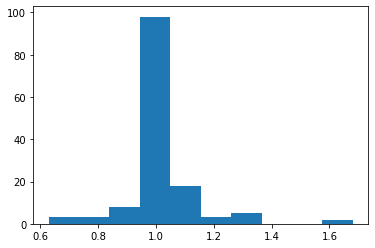

In [55]:
plt.hist(abc/np.std(Y_copy[selector[(2,31800)]],axis=0))

In [56]:
len(set(all_corrs.ravel()))

7101

In [61]:
pd.Series(all_corrs.ravel()).value_counts().value_counts()

1      1322
2       801
3       524
4       395
5       311
       ... 
109       2
116       2
96        1
113       1
117       1
Length: 116, dtype: int64

In [63]:
from pytorch_tabnet.tab_model import TabNetRegressor
import warnings
warnings.filterwarnings("ignore")

kf = KFold(n_splits = 3)
clf = TabNetRegressor(verbose = 0)

preds = np.zeros((len(X_test),140))

X = X_copy[selector[(2,32606)]][:,all_corrs.ravel()]
Y = Y_copy[selector[(2,32606)]]
X_test = X_copy[selector[(2,31800)]][:,all_corrs.ravel()]

for fold,(idx_tr, idx_va) in enumerate(kf.split(X)):

    X_tr = X[idx_tr]
    y_tr = Y[idx_tr]

    X_va = X[idx_va]
    y_va = Y[idx_va] 

    clf.fit(
      X_tr, y_tr,
      eval_set=[(X_va, y_va)],
      max_epochs = 300
    )
    preds += clf.predict(X_test)
    break


Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_mse = 0.3055399954319


RuntimeError: CUDA out of memory. Tried to allocate 876.00 MiB (GPU 0; 14.76 GiB total capacity; 11.72 GiB already allocated; 99.75 MiB free; 13.42 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [69]:
from pytorch_tabnet.tab_model import TabNetRegressor
import warnings
warnings.filterwarnings("ignore")

kf = KFold(n_splits = 3)
clf = TabNetRegressor(verbose = 20)

preds = np.zeros((len(X_test),140))

X = X_copy[selector[(2,32606)]][:,all_corrs.ravel()]
Y = Y_copy[selector[(2,32606)]]
X_test = X_copy[selector[(2,31800)]][:,all_corrs.ravel()]

for fold,(idx_tr, idx_va) in enumerate(kf.split(X)):

    X_tr = X[idx_tr]
    y_tr = Y[idx_tr]

    X_va = X[idx_va]
    y_va = Y[idx_va] 

    clf.fit(
      X_tr, y_tr,
      eval_set=[(X_va, y_va)],
      max_epochs = 300,
      loss_fn = negative_pearson_loss,
      eval_metric = [Pytorch_Metric]
    )
    preds += clf.predict(X_test)
    break

KeyboardInterrupt: 

In [4]:
with open('../input/targets-multiome-sparse-scaled/train_Citeseq_truncated_512.pkl','rb') as f: X = pickle.load(f)
with open('../input/targets-multiome-sparse-scaled/test_Citeseq_truncated_512.pkl','rb') as f: Xt = pickle.load(f)

X.shape, Xt.shape

Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
#Y = Y.loc[meta.day == 3]
Y = Y.values
Y -= Y.mean(axis=1).reshape(-1, 1)
Y /= Y.std(axis=1).reshape(-1, 1)
Y.shape

X0 = np.genfromtxt('./sparse/X0.csv',delimiter=',')

X = np.hstack((X[:,:75],X0))
X.shape
X_copy = X.copy()
Y_copy = Y.copy()

In [9]:
from pytorch_tabnet.tab_model import TabNetRegressor
import warnings
warnings.filterwarnings("ignore")

kf = KFold(n_splits = 3)
clf = TabNetRegressor(verbose = 2)

X = X_copy[selector[(2,32606)]]
Y = Y_copy[selector[(2,32606)]]
X_test = X_copy[selector[(2,31800)]]

preds = np.zeros((len(X_test),140))

for fold,(idx_tr, idx_va) in enumerate(kf.split(X)):

    X_tr = X[idx_tr]
    y_tr = Y[idx_tr]

    X_va = X[idx_va]
    y_va = Y[idx_va] 

    clf.fit(
      X_tr, y_tr,
      eval_set=[(X_va, y_va)],
      max_epochs = 1000,
      loss_fn = negative_pearson_loss,
      eval_metric = [Pytorch_Metric],
      patience = 100
    )
    preds += clf.predict(X_test)
    break

epoch 0  | loss: -0.14543| val_0_pearson: -0.24462999403476715|  0:00:00s
epoch 2  | loss: -0.47402| val_0_pearson: -0.5010600090026855|  0:00:00s
epoch 4  | loss: -0.66035| val_0_pearson: -0.6643199920654297|  0:00:01s
epoch 6  | loss: -0.75453| val_0_pearson: -0.7407500147819519|  0:00:01s
epoch 8  | loss: -0.79278| val_0_pearson: -0.7664300203323364|  0:00:02s
epoch 10 | loss: -0.80656| val_0_pearson: -0.7986199855804443|  0:00:02s
epoch 12 | loss: -0.81449| val_0_pearson: -0.8055800199508667|  0:00:03s
epoch 14 | loss: -0.81978| val_0_pearson: -0.8119500279426575|  0:00:03s
epoch 16 | loss: -0.82111| val_0_pearson: -0.8145099878311157|  0:00:04s
epoch 18 | loss: -0.82267| val_0_pearson: -0.8173900246620178|  0:00:04s
epoch 20 | loss: -0.82631| val_0_pearson: -0.8194400072097778|  0:00:05s
epoch 22 | loss: -0.82559| val_0_pearson: -0.8212800025939941|  0:00:05s
epoch 24 | loss: -0.82899| val_0_pearson: -0.8228499889373779|  0:00:06s
epoch 26 | loss: -0.83117| val_0_pearson: -0.82283

TypeError: type Tensor doesn't define __round__ method

In [21]:
X = pd.read_hdf(FP_CITE_TRAIN_INPUTS).drop(columns = constant_cols)
Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
X = X.values
Y = Y.values
all_corrs = np.load('./corrs/cite_all_corrs.npy')

In [10]:
torch.cuda.empty_cache()

In [12]:
from pytorch_tabnet.tab_model import TabNetRegressor
import warnings
warnings.filterwarnings("ignore")

kf = KFold(n_splits = 3)
clf = TabNetRegressor(verbose = 0)

X_test = X[selector[(2,31800)]][:,all_corrs.ravel()]
X = X[selector[(2,32606)]][:,all_corrs.ravel()]
Y = Y[selector[(2,32606)]]
preds = np.zeros((len(X_test),140))

for fold,(idx_tr, idx_va) in enumerate(kf.split(X)):

    X_tr = X[idx_tr]
    y_tr = Y[idx_tr]

    X_va = X[idx_va]
    y_va = Y[idx_va] 

    clf.fit(
      X_tr, y_tr,
      eval_set=[(X_va, y_va)],
      patience = 100,
      max_epochs = 1000
    )
    preds += clf.predict(X_test)
    break

RuntimeError: CUDA out of memory. Tried to allocate 438.00 MiB (GPU 0; 14.76 GiB total capacity; 13.39 GiB already allocated; 117.75 MiB free; 13.41 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [23]:
clf

TabNetRegressor(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=0, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=112000, output_dim=140, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)

In [26]:
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [8]:
%pwd

'/home/jovyan/kaggle/working'

In [5]:
saved_filepath = "./tabnet_model_test_1.zip"
loaded_clf = TabNetRegressor()
loaded_clf.load_model(saved_filepath)

/srv/conda/envs/saturn/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [6]:
X = pd.read_hdf(FP_CITE_TRAIN_INPUTS).drop(columns = constant_cols)
Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
X = X.values
Y = Y.values
all_corrs = np.load('./corrs/cite_all_corrs.npy')

In [7]:
X_test = X[selector[(2,31800)]][:,all_corrs.ravel()]

In [8]:
preds = loaded_clf.predict(X_test)

RuntimeError: CUDA out of memory. Tried to allocate 876.00 MiB (GPU 0; 14.76 GiB total capacity; 13.32 GiB already allocated; 175.75 MiB free; 13.36 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
correlation_score(Y_copy[selector[(2,31800)]],preds)

In [91]:
X = pd.read_hdf(FP_CITE_TRAIN_INPUTS).drop(columns = constant_cols)
Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
X = X.values
Y = Y.values
all_corrs = np.load('./corrs/cite_all_corrs.npy')
X_copy = X.copy()
Y_copy = Y.copy()

In [20]:
from pytorch_tabnet.tab_model import TabNetRegressor
import warnings
warnings.filterwarnings("ignore")

kf = KFold(n_splits = 3)
clf = TabNetRegressor(verbose = 0)

preds = np.zeros((len(X_test),140))

for i in range(140):

    X = X_copy[selector[(2,32606)]][:,all_corrs[i,:]]
    Y = Y_copy[selector[(2,32606)],i].reshape(-1,1)
    X_test = X_copy[selector[(2,31800)]][:,all_corrs[i,:]]

    for fold,(idx_tr, idx_va) in enumerate(kf.split(X)):

        X_tr = X[idx_tr]
        y_tr = Y[idx_tr]

        X_va = X[idx_va]
        y_va = Y[idx_va] 

        clf.fit(
          X_tr, y_tr,
          eval_set=[(X_va, y_va)],
          max_epochs = 300
        )
        preds[:,i] += clf.predict(X_test).ravel()
        break


Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_mse = 0.9399799704551697

Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_mse = 0.5641999840736389

Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_0_mse = 0.6076899766921997

Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_mse = 3.853339910507202

Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_mse = 2.632580041885376

Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_mse = 10.221830368041992

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_mse = 25.169620513916016

Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_mse = 0.7609699964523315

Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_mse = 0.5341399908065796

Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_mse = 0.9228000044822693

Early stopping occurred

In [5]:
import numpy as np
np.sqrt((2.887850046157837**2+7.404220104217529**2+0.7875699996948242**2+4.727980136871338**2+0.6770600080490112**2+2.1895999908447266**2+0.42313000559806824**2+0.8023899793624878**2+11.548489570617676**2+0.57846999168396**2+0.6830099821090698**2+0.5909799933433533**2+0.8594300150871277**2+0.6360700130462646**2+0.6531500220298767**2+0.7961400151252747**2+0.9230200052261353**2+0.7676500082015991**2+10.666230201721191**2)/19)

4.255913594329435

In [21]:
correlation_score(Y_copy[selector[(2,31800)]],preds)

0.8019529114869852

(array([ 4.,  5., 98., 21.,  5.,  4.,  1.,  0.,  0.,  2.]),
 array([0.7805349 , 0.86628394, 0.95203298, 1.03778202, 1.12353106,
        1.2092801 , 1.29502914, 1.38077818, 1.46652722, 1.55227626,
        1.6380253 ]),
 <BarContainer object of 10 artists>)

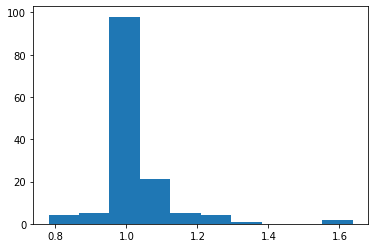

In [22]:
diff = Y_copy[selector[(2,31800)]] - preds
abc = np.sqrt(np.mean(list(map(lambda x:x**2,diff)),axis=0))
plt.hist(abc/np.std(Y_copy[selector[(2,31800)]],axis=0))

In [23]:
np.sqrt(np.mean(list(map(lambda x:x**2,diff))))

1.9386615403045362

In [94]:
from pytorch_tabnet.tab_model import TabNetRegressor
import warnings
warnings.filterwarnings("ignore")

kf = KFold(n_splits = 3)
clf = TabNetRegressor(verbose = 0)

X = X_copy[selector[(2,32606)]][:,np.array(list(set(all_corrs.ravel())))]
Y = Y_copy[selector[(2,32606)]]
X_test = X_copy[selector[(2,31800)]][:,np.array(list(set(all_corrs.ravel())))]
preds = np.zeros((len(X_test),140))

for fold,(idx_tr, idx_va) in enumerate(kf.split(X)):

    X_tr = X[idx_tr]
    y_tr = Y[idx_tr]

    X_va = X[idx_va]
    y_va = Y[idx_va] 

    clf.fit(
      X_tr, y_tr,
      eval_set=[(X_va, y_va)],
      max_epochs = 1000,
      patience = 300
    )
    preds[:,i] += clf.predict(X_test).ravel()/3
    break


Early stopping occurred at epoch 503 with best_epoch = 203 and best_val_0_mse = 2.2161600589752197


ValueError: operands could not be broadcast together with shapes (8395,) (1175300,) (8395,) 

In [103]:
preds = (clf.predict(X_test)/3)

In [101]:
Y_copy[selector[(2,31800)]].shape

(8395, 140)

In [104]:
correlation_score(Y_copy[selector[(2,31800)]],preds)

0.863105618980405

## Multiome

In [2]:
import warnings
warnings.filterwarnings("ignore")

with np.load('./sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(cell_index)
meta['range'] = range(len(meta))
selector = {}
for i in (2,3,4,7):
    for j in (32606,13176,31800):
        selector[(i,j)] = meta.loc[(meta.day == i)&(meta.donor == j)].range.values

In [6]:
with np.load('./sparse/train_multi_targets_idxcol.npz',allow_pickle=True) as data:
    multi_columns = data['columns']
with np.load('./sparse/train_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cite_columns = data['columns']

In [10]:
all_corrs = np.load('./corrs/cite_all_corrs.npy')

In [30]:
abc = [i.split("_")[0] for i in cite_columns]
abc = np.array(abc)[np.array(list(set(all_corrs.ravel())))]
multi_corrs = np.where(np.in1d(multi_columns,abc) == True)[0]

In [31]:
len(multi_corrs)

6098

In [82]:
def tab_evaluate(X,Y):
    kf = KFold(n_splits = 6)

    clfs = []
    for fold,(idx_tr, idx_va) in enumerate(kf.split(X)):
        
        clf = TabNetRegressor(verbose = 0)

        X_tr = X[idx_tr]
        y_tr = Y[idx_tr]

        X_va = X[idx_va]
        y_va = Y[idx_va] 

        clf.fit(
          X_tr, y_tr,
          eval_set=[(X_va, y_va)],
          max_epochs = 1000,
          patience = 100
        )
        clfs.append(clf)
        return clfs

In [36]:
from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
import warnings
warnings.filterwarnings("ignore")

targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
inputs_both_128 = np.load("./multi_pca/inputs_both_128.npy")
X_copy = inputs_both_128[:targets_copy.shape[0],:40]
i = 2
j = 32606
print(i,j)
targets = targets_copy.copy()
X = X_copy.copy()
targets = targets[selector[(i,j)]][:,multi_corrs]
targets = targets.toarray()
X = X_copy[selector[(i,j)]]
clfs = tab_evaluate(X,targets)

In [46]:
not_multi_corrs = np.where(np.in1d(multi_columns,abc) == False)[0]

In [56]:
i = 2
j = 32606
targets = targets_copy.copy()
to_mean = targets[selector[(i,j)]][:,not_multi_corrs]
to_mean = np.array(np.mean(to_mean,axis=0).reshape(1,-1))[0]

In [59]:
X_test = X_copy[selector[(2,31800)]]
pred = clf.predict(X_test)
to_pred = np.zeros((X_test.shape[0],targets_copy.shape[1]))
mean_index = 0
pred_index = 0
for i in range(to_pred.shape[1]):
    if i in not_multi_corrs:
        to_pred[:,i] = to_mean[mean_index]
        mean_index += 1
    else:
        to_pred[:,i] = pred[:,pred_index]
        pred_index += 1

In [60]:
pred_index

6098

In [61]:
mean_index

17320

In [62]:
len(to_mean)

17320

In [73]:
for clf in clfs:
    X_test = X_copy[selector[(2,31800)]]
    pred = clf.predict(X_test)
    to_pred = np.zeros((X_test.shape[0],targets_copy.shape[1]))
    mean_index = 0
    pred_index = 0
    for i in range(to_pred.shape[1]):
        if i in not_multi_corrs:
            to_pred[:,i] = to_mean[mean_index]
            mean_index += 1
        else:
            to_pred[:,i] = pred[:,pred_index]
            pred_index += 1
    print(correlation_score(targets_copy[selector[(2,31800)]].toarray(),to_pred))

0.6724186917445324
0.6724186917445324
0.6724186917445324


In [83]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
inputs_both_128 = np.load("./multi_pca/inputs_both_128.npy")
X_copy = inputs_both_128[:targets_copy.shape[0],:40]
i = 2
j = 32606
targets = targets_copy.copy()
X = X_copy.copy()
targets = targets[selector[(i,j)]]
# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
targets -= targets.mean(axis=1).reshape(-1, 1)
targets /= targets.std(axis=1).reshape(-1, 1)
targets = np.array(targets)
svd = TruncatedSVD(n_components = 512,random_state = 1)
Y = svd.fit_transform(targets)[:,:64]
X = X_copy[selector[(i,j)]]
models = tab_evaluate(X,Y)


Early stopping occurred at epoch 469 with best_epoch = 369 and best_val_0_mse = 7.724559783935547


In [84]:
for i in range(1):
    print(correlation_score(targets_copy[selector[(2,31800)]].toarray(),models[i].predict(X_copy[selector[(2,31800)]])@svd.components_[:64]))

0.6787939835782659


In [85]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
inputs_both_128 = np.load("./multi_pca/inputs_both_128.npy")
X_copy = inputs_both_128[:targets_copy.shape[0]]
i = 2
j = 32606
targets = targets_copy.copy()
X = X_copy.copy()
targets = targets[selector[(i,j)]]
# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
targets -= targets.mean(axis=1).reshape(-1, 1)
targets /= targets.std(axis=1).reshape(-1, 1)
targets = np.array(targets)
svd = TruncatedSVD(n_components = 512,random_state = 1)
Y = svd.fit_transform(targets)
X = X_copy[selector[(i,j)]]
models = tab_evaluate(X,Y)


Early stopping occurred at epoch 620 with best_epoch = 520 and best_val_0_mse = 4.837790012359619


In [87]:
for i in range(1):
    print(correlation_score(targets_copy[selector[(2,31800)]].toarray(),models[i].predict(X_copy[selector[(2,31800)]])@svd.components_))

0.6780830845547529
